In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from torchvision import transforms as tf

from skimage.io import imread

from pathlib import Path
import nibabel as nib

# from tqdm import tqdm

from imgaug import augmenters as iaa

from utils.display_utils import image_grid, image_gray
from utils.neuron_dataset import Neuron_dataset
from networks.Unet_no_z_pool import Unet
from utils.trainer import train_loop

In [2]:
path = 'data/'

In [5]:
img = imread(path+'train-input.tif')
# label = imread(path+'new_labels_.tif')
label3 = imread(path+'new_labels_3x3_f.tif')
label2 = imread(path+'new_labels_2x2_f.tif')
(img.shape, label3.shape, label2.shape)

((100, 1024, 1024), (100, 1024, 1024), (100, 1024, 1024))

In [6]:
img =np.rollaxis(img, 0,3)
# label = np.rollaxis(label,0,3)
label2 = np.rollaxis(label2,0,3)
label3= np.rollaxis(label3,0,3)

<Figure size 432x288 with 0 Axes>

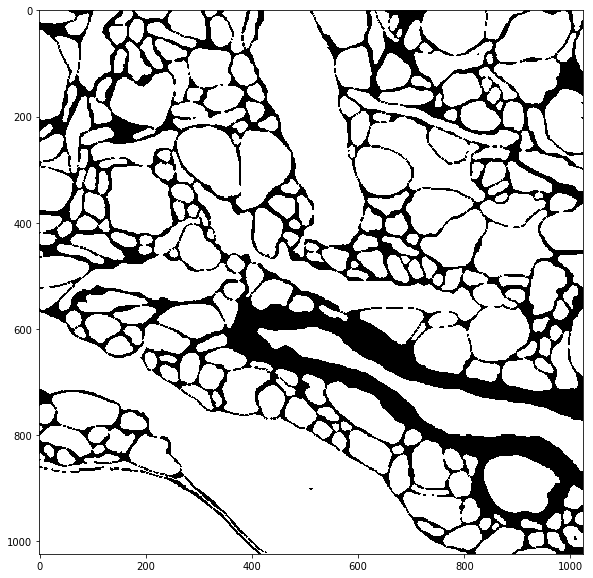

In [7]:
image_gray(label2[:,:,0])

<Figure size 432x288 with 0 Axes>

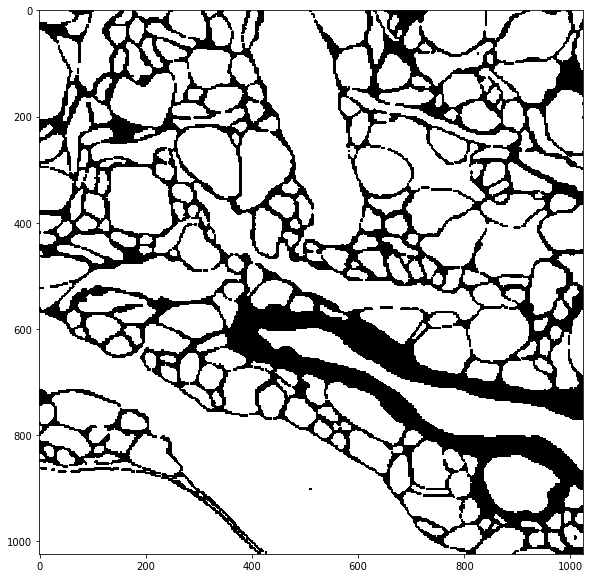

In [6]:
image_gray(label3[:,:,0])

<Figure size 432x288 with 0 Axes>

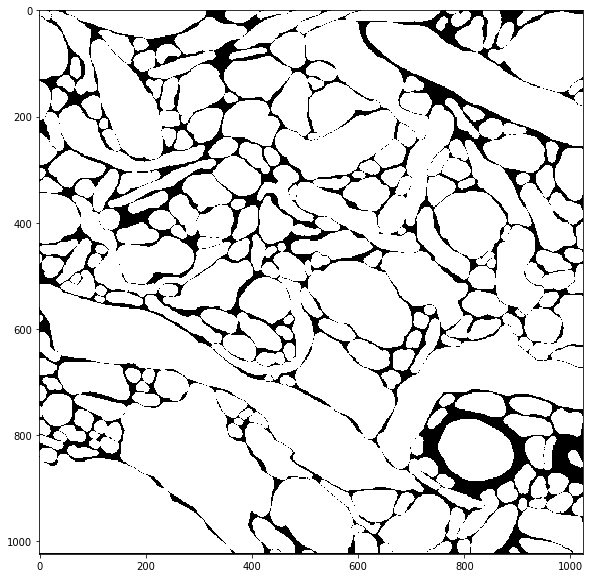

In [7]:
image_gray(label[:,:,50])

In [8]:

train_l = 10000
val_l = 2000
dim_z = 6
dim_x = 64
dim_y = 64
X_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)

X_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)

#top 80
half = 32
for i in range(0,10000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(3,77)
    
    label_pick = np.random.randint(2)
    X_train[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick==0:
        Y_train[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_train[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]

#bottom 20
for i in range(0,2000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(83,97)
   
    label_pick = np.random.randint(2)
    X_val[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick ==0:
        Y_val[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_val[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]
    
X_train = X_train/255
X_val = X_val/255

In [9]:
neuron_dataset_train = Neuron_dataset(X_train, 
                                      train=True, 
                                      masks=Y_train,
                                      transform=True)

neuron_dataset_val = Neuron_dataset(X_val, 
                                      train=True, 
                                      masks=Y_val,
                                      transform=False)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=True)



<Figure size 432x288 with 0 Axes>

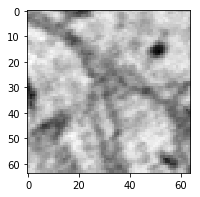

torch.Size([64, 64, 6])


In [10]:
get_image = next(iter(train_loader))
im = get_image[0][0].squeeze()
image_gray(im[:,:,4],3)
print(im.shape)

In [11]:
loop_img= get_image[0]
loop_img.shape

torch.Size([64, 1, 64, 64, 6])

In [12]:
def conv_layer(chanIn, chanOut, ks = 3, stride=1):
    return nn.Sequential(
        nn.Conv3d(chanIn, chanOut, ks, stride, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(chanOut)
        )

class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, pool = False):
        super().__init__()
        
        self.conv1 = conv_layer(chanIn, chanOut)
        self.conv2 = conv_layer(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        
class Mid_block(nn.Module):
    def __init__(self, chanIn, chanOut, ks=3, stride=1):
        super().__init__()        
        self.conv1 = nn.Conv3d(chanIn, chanOut, ks, padding=1)
        self.conv2 = nn.Conv3d(chanOut, chanOut, ks, padding=1)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [13]:
class test_net(nn.Module):
    def __init__(self):
        super(test_net, self).__init__()
        
        self.down1 = Conv_block(1,16)
        self.down2 = Conv_block(16, 32)
        self.down3 = Conv_block(32,64)
        self.down4 = Conv_block(64,128)
        
        self.mid = Mid_block(128,256)
        
        self.upt3 = nn.ConvTranspose3d(256,128,(2,2,1),(2,2,1))
        self.up3 =Conv_block(128,128)#(256,128)
        self.upt2 = nn.ConvTranspose3d(128, 64,(2,2,2),(2,2,2))
        self.up2 = Conv_block(64,64)
        self.upt1 = nn.ConvTranspose3d(64, 32,(2,2,1),(2,2,1))
        self.up1 = Conv_block(32,32)
        self.upt0 = nn.ConvTranspose3d(32, 16,(2,2,1),(2,2,1))
        self.up0 = Conv_block(16,16)
        self.last = nn.Conv3d(16,1,1) #output channels 1 or 2
        
        self.maxPool = nn.MaxPool3d((2,2,1))
        self.maxPool2 = nn.MaxPool3d((2,2,2))
        self.dropout = nn.Dropout3d(p=.50, inplace=True)
        
    
    def forward(self, x):
#         print('input shape', x.shape)
        x1 = self.down1(x)
        p1 = self.maxPool(x1)
        p1 = self.dropout(p1)
#         print('p1 shape', p1.shape)
        x2 = self.down2(p1)
#         print('x2 shape', x2.shape)
        p2 = self.maxPool(x2)
        p2 = self.dropout(p2)
        
        x3 = self.down3(p2)
        p3 = self.maxPool2(x3)
        p3 = self.dropout(p3)
        
        x4 = self.down4(p3)
        p4 = self.maxPool(x4)
        p4 = self.dropout(p4)
#         print('looking p4', p4.shape)
        xmid = self.mid(p4)
        
        xu3 = self.upt3(xmid)
        
#         print('xu3', xu3.shape)
#         print('x4', x4.shape)
        cat3 = torch.add(x4,xu3)#([x4, xu3],1) #x4,xu3
#         print('cat3', cat3.shape)
        xu3 = self.up3(cat3)
        
        xu2 = self.upt2(xu3)
#         print('x3', x3.shape)
#         print('xu2', xu2.shape)
        cat2 = torch.add(x3, xu2)
        xu2 = self.up2(cat2)
        
        xu1 = self.upt1(xu2)
        cat1 = torch.add(x2,xu1)
        xu1 = self.up1(cat1)
        
        xu0 = self.upt0(xu1)
        cat0 = torch.add(x1,xu0)
        xu0 = self.up0(cat0)
        out = self.last(xu0)
#         print('output shape ',out.shape)
        return (out)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
model = test_net()
model.to(device)

test_net(
  (down1): Conv_block(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Conv_block(
    (conv1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down3): Conv_block(
    (conv1

In [16]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=.1)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[400,800,1000,1500], 
                                                 gamma=0.1)
epochs = 2000



EPOCH:  1
Training loss:....... 0.6738550769295663
Validation loss:..... 0.667877372354269
NEW BEST Loss: 0.667877372354269 ........old best:99999



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 432x288 with 0 Axes>

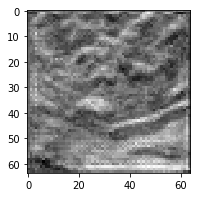

<Figure size 432x288 with 0 Axes>

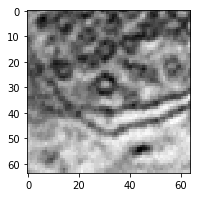


EPOCH:  2
Training loss:....... 0.6197012321204897
Validation loss:..... 0.6342185940593481
NEW BEST Loss: 0.6342185940593481 ........old best:0.667877372354269


EPOCH:  3
Training loss:....... 0.583941919408786
Validation loss:..... 0.5976771172136068
NEW BEST Loss: 0.5976771172136068 ........old best:0.6342185940593481


EPOCH:  4
Training loss:....... 0.5521989100298305
Validation loss:..... 0.5632370039820671
NEW BEST Loss: 0.5632370039820671 ........old best:0.5976771172136068


EPOCH:  5
Training loss:....... 0.5257731497667397
Validation loss:..... 0.5372311621904373
NEW BEST Loss: 0.5372311621904373 ........old best:0.5632370039820671


EPOCH:  6
Training loss:....... 0.5038052645458537
Validation loss:..... 0.5124726444482803
NEW BEST Loss: 0.5124726444482803 ........old best:0.5372311621904373


EPOCH:  7
Training loss:....... 0.48752040885815956
Validation loss:..... 0.49444841779768467
NEW BEST Loss: 0.49444841779768467 ........old best:0.5124726444482803


EPOCH:  8
Trai

<Figure size 432x288 with 0 Axes>

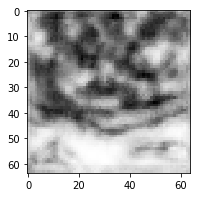

<Figure size 432x288 with 0 Axes>

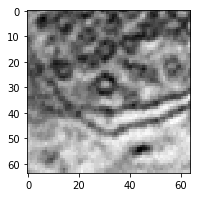


EPOCH:  22
Training loss:....... 0.41305825398985746
Validation loss:..... 0.43506452441215515

EPOCH:  23
Training loss:....... 0.409800698992553
Validation loss:..... 0.4192140959203243
NEW BEST Loss: 0.4192140959203243 ........old best:0.4259915305301547


EPOCH:  24
Training loss:....... 0.4069891604268627
Validation loss:..... 0.40836021956056356
NEW BEST Loss: 0.40836021956056356 ........old best:0.4192140959203243


EPOCH:  25
Training loss:....... 0.40544813605630475
Validation loss:..... 0.41535449493676424

EPOCH:  26
Training loss:....... 0.40335125376464454
Validation loss:..... 0.4056059643626213
NEW BEST Loss: 0.4056059643626213 ........old best:0.40836021956056356


EPOCH:  27
Training loss:....... 0.400087664841087
Validation loss:..... 0.4035905282944441
NEW BEST Loss: 0.4035905282944441 ........old best:0.4056059643626213


EPOCH:  28
Training loss:....... 0.39891117317661356
Validation loss:..... 0.3999748043715954
NEW BEST Loss: 0.3999748043715954 ........old best:

<Figure size 432x288 with 0 Axes>

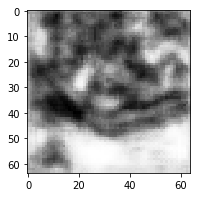

<Figure size 432x288 with 0 Axes>

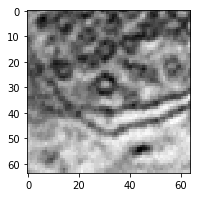


EPOCH:  42
Training loss:....... 0.36842787987107684
Validation loss:..... 0.3670399924740195

EPOCH:  43
Training loss:....... 0.3670669105022576
Validation loss:..... 0.35904984548687935
NEW BEST Loss: 0.35904984548687935 ........old best:0.36288279481232166


EPOCH:  44
Training loss:....... 0.364466553470891
Validation loss:..... 0.3562589921057224
NEW BEST Loss: 0.3562589921057224 ........old best:0.35904984548687935


EPOCH:  45
Training loss:....... 0.3628989505540034
Validation loss:..... 0.35692749358713627

EPOCH:  46
Training loss:....... 0.3609798184246015
Validation loss:..... 0.3560060113668442
NEW BEST Loss: 0.3560060113668442 ........old best:0.3562589921057224


EPOCH:  47
Training loss:....... 0.3589594768490761
Validation loss:..... 0.3644451694563031

EPOCH:  48
Training loss:....... 0.3580251793572857
Validation loss:..... 0.35806323681026697

EPOCH:  49
Training loss:....... 0.3555705951657265
Validation loss:..... 0.3458258006721735
NEW BEST Loss: 0.345825800672

<Figure size 432x288 with 0 Axes>

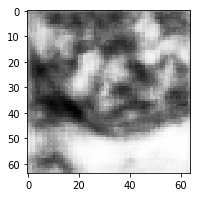

<Figure size 432x288 with 0 Axes>

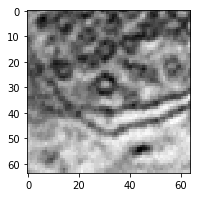


EPOCH:  62
Training loss:....... 0.3348365851268647
Validation loss:..... 0.3207999588921666
NEW BEST Loss: 0.3207999588921666 ........old best:0.3272500578314066


EPOCH:  63
Training loss:....... 0.3332716972584937
Validation loss:..... 0.3278773408383131

EPOCH:  64
Training loss:....... 0.3316947929798418
Validation loss:..... 0.31854249257594347
NEW BEST Loss: 0.31854249257594347 ........old best:0.3207999588921666


EPOCH:  65
Training loss:....... 0.33146860360339947
Validation loss:..... 0.3169236099347472
NEW BEST Loss: 0.3169236099347472 ........old best:0.31854249257594347


EPOCH:  66
Training loss:....... 0.3299637989253755
Validation loss:..... 0.32356512174010277

EPOCH:  67
Training loss:....... 0.32809637059831315
Validation loss:..... 0.3137082541361451
NEW BEST Loss: 0.3137082541361451 ........old best:0.3169236099347472


EPOCH:  68
Training loss:....... 0.32700034425516794
Validation loss:..... 0.31528187170624733

EPOCH:  69
Training loss:....... 0.32509165205013

In [ ]:
save_bst = 'experiments/test_elem_add/temp_best.pth'
save_last = 'experiments/test_elem_add/temp_2000.pth'
hist = train_loop(train_loader,val_loader, model,optimizer,scheduler,criterion,
                 save_bst,save_last, epochs, loop_img)